#### This AdvGAN is an implementation of the following paper: ref: https://arxiv.org/pdf/1801.02610.pdf

In this notebook we have been using MNIST however this advGAN architecture could be adapted to other datasets. Provided that the shape of the tensor graphs are adjusted accordingly.





In [1]:
# Need mount drive as I work on google colab
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
# This path below are specifically related to my directory on colab where I ran this project. 
#You'll need to set yours depending on whether you execute this code in local or in the cloud somewhere.


!cd gdrive && cd 'My Drive' && mkdir weightsV2
!cd gdrive && cd 'My Drive' && cd weightsV2 && mkdir generatorV2
!cd gdrive && cd 'My Drive' && cd weightsV2 && mkdir discriminatorV2
!cd gdrive && cd 'My Drive' && cd weightsV2 && mkdir targetV2

In [0]:
# the discriminator architecture


import tensorflow as tf

def discriminator(x, training):
	with tf.variable_scope('d_weights', reuse=tf.AUTO_REUSE):
		# input_layer = tf.reshape(x, [-1, 28, 28, 1])

		conv1 = tf.layers.conv2d(
							inputs=x,
							filters=8,
							kernel_size=4,
							strides=2,
							padding="valid",
							activation=None)
		conv1 = tf.nn.leaky_relu(conv1, alpha=0.2)

		
		conv2 = tf.layers.conv2d(
							inputs=conv1,
							filters=16,
							kernel_size=4,
							strides=2,
							padding="valid",
							activation=None)

		in1 = tf.contrib.layers.instance_norm(conv2)
		conv2 = tf.nn.leaky_relu(in1, alpha=0.2)

		conv3 = tf.layers.conv2d(
							inputs=conv2,
							filters=32,
							kernel_size=4,
							strides=2,
							padding="valid",
							activation=None)

		#in2 = tf.contrib.layers.instance_norm(conv3)
		in2 = tf.contrib.layers.instance_norm(conv3)
		conv3 = tf.nn.leaky_relu(in2, alpha=0.2)
		flat = tf.layers.flatten(conv3)
		logits = tf.layers.dense(flat, 1)

		probs = tf.nn.sigmoid(logits)

		return logits, probs


In [0]:

import tensorflow as tf

# helper functions for the generator


def ConvInstNormRelu(x, filters, kernel_size=3, strides=1):
	Conv = tf.layers.conv2d(
						inputs=x,
						filters=filters,
						kernel_size=kernel_size,
						strides=strides,
						padding="same",
						activation=None)

	InstNorm = tf.contrib.layers.instance_norm(Conv)

	return tf.nn.relu(InstNorm)



def TransConvInstNormRelu(x, filters, kernel_size=3, strides=2):
	TransConv = tf.layers.conv2d_transpose(
						inputs=x,
						filters=filters,
						kernel_size=kernel_size,
						strides=strides,
						padding="same",
						activation=None)

	InstNorm = tf.contrib.layers.instance_norm(TransConv)

	return tf.nn.relu(InstNorm)

# helper function for residual block of 2 convolutions with same num filters
# in the same style as ConvInstNormRelu
def ResBlock(x, training, filters=32, kernel_size=3, strides=1):
	conv1 = tf.layers.conv2d(
						inputs=x,
						filters=filters,
						kernel_size=kernel_size,
						strides=strides,
						padding="same",
						activation=None)

	conv1_norm = tf.layers.batch_normalization(conv1, training=training)

	conv1_relu = tf.nn.relu(conv1_norm)

	conv2 = tf.layers.conv2d(
						inputs=conv1_relu,
						filters=filters,
						kernel_size=kernel_size,
						strides=strides,
						padding="same",
						activation=None)

	conv2_norm = tf.layers.batch_normalization(conv2, training=training)


	return x + conv2_norm


def generator(x, training):
	with tf.variable_scope('g_weights', reuse=tf.AUTO_REUSE):
		# input_layer = tf.reshape(x, [-1, 28, 28, 1])

		# define first 3 conv + inst + relu layers
		c1 = ConvInstNormRelu(x, filters=8, kernel_size=3, strides=1)
		d1 = ConvInstNormRelu(c1, filters=16, kernel_size=3, strides=2)
		d2 = ConvInstNormRelu(d1, filters=32, kernel_size=3, strides=2)

		# define residual blocks
		rb1 = ResBlock(d2, training, filters=32)
		rb2 = ResBlock(rb1, training, filters=32)
		rb3 = ResBlock(rb2, training, filters=32)
		rb4 = ResBlock(rb3, training, filters=32)

		# upsample using conv transpose
		u1 = TransConvInstNormRelu(rb4, filters=16, kernel_size=3, strides=2)
		u2 = TransConvInstNormRelu(u1, filters=8, kernel_size=3, strides=2)

		# final layer block
		out = tf.layers.conv2d_transpose(
						inputs=u2,
						filters=x.get_shape()[-1].value, # or 3 if RGB image
						kernel_size=3,
						strides=1,
						padding="same",
						activation=None)

		# out = tf.contrib.layers.instance_norm(out)

		return tf.nn.tanh(out)


In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
from keras.utils import to_categorical
from keras.datasets import mnist





class Target:
	def __init__(self, lr=0.001, epochs=10, n_input=28, n_classes=10, batch_size=16,\
					restore=0):
		self.lr = lr
		self.epochs = epochs
		self.n_input = 28
		self.n_classes = 10
		self.batch_size = batch_size
		self.restore = restore

		os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

	# randomly shuffle a dataset 
	def shuffle(self, X, Y):
		rands = random.sample(range(X.shape[0]),X.shape[0])
		return X[rands], Y[rands]

	# get the next batch based on x, y, and the iteration (based on batch_size)
	def next_batch(self, X, Y, i, batch_size):
		idx = i * batch_size
		idx_n = i * batch_size + batch_size
		return X[idx:idx_n], Y[idx:idx_n]


	# Now we define our target model (the model we aim to attack)
	def ModelC(self, x):
		with tf.variable_scope('ModelC', reuse=tf.AUTO_REUSE):
			#input_layer = tf.reshape(x, [-1, 28, 28, 1])

			conv1 = tf.layers.conv2d(
								inputs=x,
								filters=32,
								kernel_size=3,
								padding="same",
								activation=tf.nn.relu)
			
			conv2 = tf.layers.conv2d(
								inputs=conv1,
								filters=32,
								kernel_size=3,
								padding="same",
								activation=tf.nn.relu)

			pool1 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)

			conv3 = tf.layers.conv2d(
								inputs=pool1,
								filters=64,
								kernel_size=3,
								padding="same",
								activation=tf.nn.relu)

			conv4 = tf.layers.conv2d(
								inputs=conv3,
								filters=64,
								kernel_size=3,
								padding="same",
								activation=tf.nn.relu)

			pool2 = tf.layers.max_pooling2d(inputs=conv4, pool_size=[2, 2], strides=2)

			pool2_flatten = tf.contrib.layers.flatten(pool2)

			fc1 = tf.layers.dense(inputs=pool2_flatten, units=200, activation=tf.nn.relu)

			fc2 = tf.layers.dense(inputs=fc1, units=200, activation=tf.nn.relu)

			logits = tf.layers.dense(inputs=fc2, units=self.n_classes, activation=None)

			probs = tf.nn.softmax(logits)

			return logits, probs



	def train(self, X, Y, X_test, Y_test):
		# define placeholders for input data
		x = tf.placeholder(tf.float32, [None, X.shape[1], X.shape[2], X.shape[3]])
		y = tf.placeholder(tf.float32, [None, self.n_classes])

		# define compute graph
		logits, _ = self.ModelC(x)

		# define cost
		cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=y))

		# optimizer
		optimizer = tf.train.AdamOptimizer(learning_rate=self.lr).minimize(cost)

		saver = tf.train.Saver()

		# Initializing the variables
		init = tf.global_variables_initializer()

		sess = tf.Session()
		sess.run(init)

		total_batch = int(X.shape[0] / self.batch_size)

		for epoch in range(1, self.epochs + 1):
			avg_cost = 0.

			for i in range(total_batch):
				batch_x, batch_y = self.next_batch(X, Y, i, self.batch_size)
				
				_, c = sess.run([optimizer, cost], feed_dict={x: batch_x, y: batch_y})

				avg_cost += c / total_batch

			print("Epoch:", '%04d' % (epoch), "cost=", "{:.9f}".format(avg_cost))

		# Test model
		correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))

		# Calculate accuracy
		accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

		accs = []

		total_test_batch = int(X_test.shape[0] / self.batch_size)
		for i in range(total_test_batch):
			batch_x, batch_y = self.next_batch(X_test, Y_test, i, self.batch_size)
			#batch_x = dataset.train.permute(batch_x, idxs)
			accs.append(accuracy.eval({x: batch_x, y: batch_y}, session=sess))

		print('accuracy of test set: {}'.format(sum(accs) / len(accs)))

		saver.save(sess, "./gdrive/My Drive/weightsV2/targetV2/weights_target_modelV2.ckpt")
		sess.close() 

        

# LOADING MNIST
if __name__ == '__main__':
	(X,y), (X_test,y_test) = mnist.load_data()
	X = np.divide(X, 255.0)
	X_test = np.divide(X_test, 255.0)
	X = X.reshape(X.shape[0], 28, 28, 1)
	X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)
	y = to_categorical(y, num_classes=10)
	y_test = to_categorical(y_test, num_classes=10)
	cnn = Target()
	cnn.train(X, y, X_test, y_test) # We train the model # MAKE SURE THE TARGET MODEL IS TRAINED BEFORE MOVING FORWARD !!!!

Using TensorFlow backend.
W0705 12:12:00.968019 140625910572928 deprecation.py:323] From <ipython-input-3-7aeb4408afe4>:50: conv2d (from tensorflow.python.layers.convolutional) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
W0705 12:12:00.974291 140625910572928 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0705 12:12:01.226019 140625910572928 deprecation.py:323] From <ipython-input-3-7aeb4408afe4>:59: max_pooling2d (from tensorflow.python.layers.pooling) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.MaxPooling2D instead.
W0705 12:12:02.413367 14062591057

Epoch: 0001 cost= 0.111219544
Epoch: 0002 cost= 0.045070848
Epoch: 0003 cost= 0.031019737
Epoch: 0004 cost= 0.024746449
Epoch: 0005 cost= 0.019493017
Epoch: 0006 cost= 0.017853546
Epoch: 0007 cost= 0.015687718
Epoch: 0008 cost= 0.014743138
Epoch: 0009 cost= 0.013820874
Epoch: 0010 cost= 0.011349213
accuracy of test set: 0.9902


In [0]:
import tensorflow as tf
from keras.datasets import mnist
from keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os, sys
import random

adversarials =[] # create an empty list to append adversarial images 


# randomly shuffle a dataset 
def shuffle(X, Y):
	rands = random.sample(range(X.shape[0]),X.shape[0])
	return X[rands], Y[rands]

# get the next batch based on x, y, and the iteration (based on batch_size)
def next_batch(X, Y, i, batch_size):
	idx = i * batch_size
	idx_n = i * batch_size + batch_size
	return X[idx:idx_n], Y[idx:idx_n]

# loss function to encourage misclassification after perturbation
def adv_loss(preds, labels, is_targeted):
	real = tf.reduce_sum(labels * preds, 1)
	other = tf.reduce_max((1 - labels) * preds - (labels * 10000), 1)
	if is_targeted:
		return tf.reduce_sum(tf.maximum(0.0, other - real))
	return tf.reduce_sum(tf.maximum(0.0, real - other))

# loss function to influence the perturbation to be as close to 0 as possible
def perturb_loss(preds, thresh=0.3):
	zeros = tf.zeros((tf.shape(preds)[0]))
	return tf.reduce_mean(tf.maximum(zeros, tf.norm(tf.reshape(preds, (tf.shape(preds)[0], -1)), axis=1) - thresh))


# function that defines ops, graphs, and training procedure for AdvGAN framework
def AdvGAN(X, y, X_test, y_test, epochs=50, batch_size=128, target=-1, thresh = 0.3):
	# placeholder definitions
	x_pl = tf.placeholder(tf.float32, [None, X.shape[1], X.shape[2], X.shape[3]]) # image placeholder
	t = tf.placeholder(tf.float32, [None, y.shape[-1]]) # target placeholder
	is_training = tf.placeholder(tf.bool, [])

	#-----------------------------------------------------------------------------------
	# MODEL DEFINITIONS
	is_targeted = False
	if target in range(0, y.shape[-1]):
		is_targeted = True

	# gather target model
	f = Target()

	# generate perturbation, add to original input image(s)
	perturb = tf.clip_by_value(generator(x_pl, is_training), -thresh, thresh)
	x_perturbed = perturb + x_pl
	x_perturbed = tf.clip_by_value(x_perturbed, 0, 1)

	# pass real and perturbed image to discriminator and the target model
	d_real_logits, d_real_probs = discriminator(x_pl, is_training)
	d_fake_logits, d_fake_probs = discriminator(x_perturbed, is_training)
	
	# pass real and perturbed images to the model we are trying to fool
	f_real_logits, f_real_probs = f.ModelC(x_pl)
	f_fake_logits, f_fake_probs = f.ModelC(x_perturbed)

	
	# generate labels for discriminator (optionally smooth labels for stability)
	smooth = 0.0
	d_labels_real = tf.ones_like(d_real_probs) * (1 - smooth)
	d_labels_fake = tf.zeros_like(d_fake_probs)

	#-----------------------------------------------------------------------------------
	# LOSS DEFINITIONS
	# discriminator loss
	d_loss_real = tf.losses.mean_squared_error(predictions=d_real_probs, labels=d_labels_real)
	d_loss_fake = tf.losses.mean_squared_error(predictions=d_fake_probs, labels=d_labels_fake)
	d_loss = d_loss_real + d_loss_fake

	# generator loss
	g_loss_fake = tf.losses.mean_squared_error(predictions=d_fake_probs, labels=tf.ones_like(d_fake_probs))

	# perturbation loss (minimize overall perturbation)
	l_perturb = perturb_loss(perturb, thresh)

	# adversarial loss (encourage misclassification)
	l_adv = adv_loss(f_fake_probs, t, is_targeted)

	# weights for generator loss function
    # This weight below alpha and beta are very important hyperparameters for the ADV_GAN to work properly
    # They basically define the trade-off for the generator loss function. THE GENERATOR HAS 3 DIFFERENTS LOSS !
	alpha = 2.0
	beta = 5.0
	g_loss = l_adv + alpha*g_loss_fake + beta*l_perturb 

	# ----------------------------------------------------------------------------------
	# gather variables for training/restoring
	t_vars = tf.trainable_variables()
	f_vars = [var for var in t_vars if 'ModelC' in var.name]
	d_vars = [var for var in t_vars if 'd_' in var.name]
	g_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='g_weights')

	# define optimizers for discriminator and generator
	update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
	with tf.control_dependencies(update_ops):
		d_opt = tf.train.AdamOptimizer().minimize(d_loss, var_list=d_vars)
		g_opt = tf.train.AdamOptimizer(learning_rate=0.001).minimize(g_loss, var_list=g_vars)

	# create saver objects for the target model, generator, and discriminator
	saver = tf.train.Saver(f_vars)
	g_saver = tf.train.Saver(g_vars)
	d_saver = tf.train.Saver(d_vars)

	init  = tf.global_variables_initializer()

	sess  = tf.Session()
	sess.run(init)

	# load the pretrained target model
	try:
		saver.restore(sess, "./gdrive/My Drive/weightsV2/targetV2/weights_target_modelV2.ckpt")
	except:
		print("make sure to train the target model first...") # IMPORTANT DO NOT FORGET THAT 
		sys.exit(1)

	total_batches = int(X.shape[0] / batch_size)

	for epoch in range(0, epochs):

		X, y = shuffle(X, y)
		loss_D_sum = 0.0
		loss_G_fake_sum = 0.0
		loss_perturb_sum = 0.0
		loss_adv_sum = 0.0

		for i in range(total_batches):

			batch_x, batch_y = next_batch(X, y, i, batch_size)

			# if targeted, create one hot vectors of the target
			if is_targeted:
				targets = np.full((batch_y.shape[0],), target)
				batch_y = np.eye(y.shape[-1])[targets]

			# train the discriminator first n times
            # HERE WE ARE TRAINING THE DISCRIMINATOR 1 TIME
			for _ in range(1):
				_, loss_D_batch = sess.run([d_opt, d_loss], feed_dict={x_pl: batch_x, \
																	   is_training: True})

			# train the generator n times
            # HERE WE ARE TRAINING THE GENERATOR 2 TIMES => We want more weight of the generator.
			for _ in range(2):
				_, loss_G_fake_batch, loss_adv_batch, loss_perturb_batch = \
									sess.run([g_opt, g_loss_fake, l_adv, l_perturb], \
												feed_dict={x_pl: batch_x, \
														   t: batch_y, \
														   is_training: True})
			loss_D_sum += loss_D_batch
			loss_G_fake_sum += loss_G_fake_batch
			loss_perturb_sum += loss_perturb_batch
			loss_adv_sum += loss_adv_batch

		print("epoch %d:\nloss_D: %.3f, loss_G_fake: %.3f, \
				\nloss_perturb: %.3f, loss_adv: %.3f, \n" %
				(epoch + 1, loss_D_sum/total_batches, loss_G_fake_sum/total_batches,
				loss_perturb_sum/total_batches, loss_adv_sum/total_batches))

		if epoch % 10 == 0:
			g_saver.save(sess, "gdrive/My Drive/weightsV2/generatorV2/weights_genV2.ckpt")
			d_saver.save(sess, "gdrive/My Drive/weightsV2/discriminatorV2/weights_discV2.ckpt")

	# evaluate the test set
	correct_prediction = tf.equal(tf.argmax(f_fake_probs, 1), tf.argmax(t, 1))
	accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
	accs = []
	total_batches_test = int(X_test.shape[0] / batch_size)
	for i in range(total_batches_test):
		batch_x, batch_y = next_batch(X_test, y_test, i, batch_size)
		acc, x_pert = sess.run([accuracy, x_perturbed], feed_dict={x_pl: batch_x, t: batch_y, is_training: False})
		adversarials.append(x_pert)  # append adversarial images    


	print('finished training, saving weights')
	g_saver.save(sess, "gdrive/My Drive/weightsV2/generatorV2/weights_genV2.ckpt")
	d_saver.save(sess, "gdrive/My Drive/weightsV2/discriminatorV2/weights_discV2.ckpt")
                 

In [59]:
tf.reset_default_graph() # Reset the default graph
AdvGAN(X, y, X_test, y_test, batch_size=128, epochs=7, target=-1) # Running the advGAN attack

epoch 1:
loss_D: 0.500, loss_G_fake: 0.250, 				
loss_perturb: 5.718, loss_adv: 10.584, 

epoch 2:
loss_D: 0.500, loss_G_fake: 0.250, 				
loss_perturb: 3.947, loss_adv: 1.070, 

epoch 3:
loss_D: 0.500, loss_G_fake: 0.250, 				
loss_perturb: 3.254, loss_adv: 0.807, 

epoch 4:
loss_D: 0.500, loss_G_fake: 0.250, 				
loss_perturb: 2.977, loss_adv: 0.711, 

epoch 5:
loss_D: 0.500, loss_G_fake: 0.250, 				
loss_perturb: 2.815, loss_adv: 0.624, 

epoch 6:
loss_D: 0.500, loss_G_fake: 0.250, 				
loss_perturb: 2.685, loss_adv: 0.590, 

epoch 7:
loss_D: 0.500, loss_G_fake: 0.250, 				
loss_perturb: 2.589, loss_adv: 0.530, 

finished training, saving weights


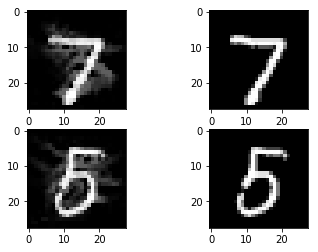

In [60]:
# plotting the just 2 generated adversarial versus their respective clean images:

adv_images = np.array(adversarials).reshape(78*128,28,28,1)

f, axarr = plt.subplots(2,2)
axarr[0,0].imshow(np.squeeze(adv_images [0]), cmap='Greys_r')
axarr[0,1].imshow(np.squeeze(X_test[0]), cmap='Greys_r')
axarr[1,0].imshow(np.squeeze(adv_images [45]), cmap='Greys_r')
axarr[1,1].imshow(np.squeeze(X_test[45]), cmap='Greys_r')



In [0]:
threshold = np.linspace(0.0,1,7) # setting different threshold values => The threshold here defined the magnitude of the pertubation. 
adv_imarray = np.zeros((len(threshold),78*128,28,28,1)) # creating empting array to retrieve all the adversarial per threshold values
for i in range (len(threshold)):
    tf.reset_default_graph() 
    AdvGAN(X, y, X_test, y_test, batch_size=128, epochs=5, target=-1, thresh =threshold[i])
adv_imarray[i] = np.array(adversarials).reshape(78*128,28,28,1)
  
# We set 7 different threshold values and there 5 epochs per attack. 
# We can observe for each epochs how the loss_pertub and loss_adv change as we increase the threshold values below:

epoch 1:
loss_D: 0.500, loss_G_fake: 0.250, 				
loss_perturb: 0.000, loss_adv: 127.000, 

epoch 2:
loss_D: 0.500, loss_G_fake: 0.250, 				
loss_perturb: 0.000, loss_adv: 127.000, 

epoch 3:
loss_D: 0.500, loss_G_fake: 0.250, 				
loss_perturb: 0.000, loss_adv: 127.002, 

epoch 4:
loss_D: 0.500, loss_G_fake: 0.250, 				
loss_perturb: 0.000, loss_adv: 127.000, 

epoch 5:
loss_D: 0.500, loss_G_fake: 0.250, 				
loss_perturb: 0.000, loss_adv: 127.002, 

finished training, saving weights
epoch 1:
loss_D: 0.500, loss_G_fake: 0.250, 				
loss_perturb: 4.013, loss_adv: 60.487, 

epoch 2:
loss_D: 0.500, loss_G_fake: 0.250, 				
loss_perturb: 3.668, loss_adv: 24.557, 

epoch 3:
loss_D: 0.500, loss_G_fake: 0.250, 				
loss_perturb: 3.361, loss_adv: 18.775, 

epoch 4:
loss_D: 0.500, loss_G_fake: 0.250, 				
loss_perturb: 3.194, loss_adv: 16.890, 

epoch 5:
loss_D: 0.500, loss_G_fake: 0.250, 				
loss_perturb: 3.087, loss_adv: 15.813, 

finished training, saving weights
epoch 1:
loss_D: 0.500, los